# Making a Freind ChatBot Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer

batchsiz = 64
blocksiz = 128
epochs = 600
evalIntervals = 100
lr = 3e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
evaliters = 100
nemb = 112
nhead = 2
nlayers = 2
dropout = 0.1

with open("/kaggle/input/friend-bot/dialogs.txt", 'r', encoding="utf-8") as file:
    txt = file.read()

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-1.7B-Instruct")

def enc(txt, tok):
    tokns = tok(txt, return_tensors="pt", truncation=True, padding=False)["input_ids"]
    return tokns.flatten()

data = torch.tensor(enc(txt, tokenizer), dtype=torch.long)

n = int(0.9*len(data))
trainData = data[:n]
valData = data[n:]

vocabsiz = tokenizer.vocab_size
print(f"vocab siz: {vocabsiz}")

def getBatch(split):
    dataset = trainData if split == 'train' else valData
    ix = torch.randint(0, len(dataset) - blocksiz, (batchsiz,))

    x = torch.stack([dataset[i:i+blocksiz] for i in ix])
    y = torch.stack([dataset[i+1:i+blocksiz+1] for i in ix])
    x, y = x.to(device), y.to(device)

    return x, y

def estimateLoss():
    out = { }
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(evaliters)
        for k in range(evaliters):
            x, y = getBatch(split)
            logits, loss = model(x, y)
            losses[k] = loss.item()
        out[split] = losses.mean()

    model.train()
    return out

class Head(nn.Module):
    def __init__(self, headsiz):
        super().__init__()
        self.key = nn.Linear(nemb, headsiz, bias=False)
        self.quary = nn.Linear(nemb, headsiz, bias=False)
        self.value = nn.Linear(nemb, headsiz, bias=False)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer("tril", torch.tril(torch.ones(blocksiz, blocksiz)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.quary(x)

        w = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5
        w = w.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
        w = F.softmax(w, dim=-1)
        v = self.value(x)
        out = w @ v

        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, nhead, headsiz):
        super().__init__()
        self.heads = nn.ModuleList([Head(headsiz) for _ in range(nhead)])
        self.proj = nn.Linear(headsiz * nhead, nemb)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads])
        out = self.dropout(self.proj(x))
        return out

class FeedForwadNetwork(nn.Module):
    def __init__(self, nemb):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nemb, 4 * nemb),
            nn.ReLU(),
            nn.Linear(4 * nemb, nemb),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)
class Block(nn.Module):
    def __init__(self, nemb, nhead):
        super().__init__()
        headsiz = nemb // nhead
        self.self_attn = MultiHeadAttention(nhead, headsiz)
        self.ffn = FeedForwadNetwork(nemb)
        self.ln_1 = nn.LayerNorm(nemb)
        self.ln_2 = nn.LayerNorm(nemb)

    def forward(self, x):
        x = x + self.self_attn(self.ln_1(x))
        x = x + self.ffn(self.ln_2(x))
        return x

class GPTLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.wte = nn.Embedding(vocabsiz, nemb)
        self.wpe = nn.Embedding(blocksiz, nemb)
        self.block = nn.Sequential(*[Block(nemb, nhead=nhead) for _ in range(nlayers)])
        self.ln_finl = nn.LayerNorm(nemb)
        self.lm_Head = nn.Linear(nemb, vocabsiz)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, ix, targt=None):
        B, T = ix.shape
        tokEmb = self.wte(ix)
        posEmb = self.wpe(torch.arange(T, device=device))

        x = tokEmb + posEmb
        for block in self.block:
            x = block(x)
        x =  self.ln_finl(x)

        logits = self.lm_Head(x)

        if targt is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targt = targt.view(B*T)
            loss = F.cross_entropy(logits, targt)

        return logits, loss

    def genarate(self,ix, maxNewTok, tokenizer):
        # idx is (B, T) array of indices in the current context
        for _ in range(maxNewTok):
            # crop idx to the last block_size tokens
            ixCond = ix[:, -blocksiz:]

            # predict
            logits, loss = self(ixCond)

            # focus only on the last time step
            logits = logits[:, -1, :]

            probs = F.softmax(logits, dim=-1)

            # sample from the distribution
            ixNxt = torch.multinomial(probs, num_samples=1)

            # append sampled index to the running sequence
            ix = torch.cat((ix, ixNxt), dim=1)

        genTxt = tokenizer.decode(ix[0].cpu().numpy().tolist(), skip_special_tokens=True)
        return genTxt

model = GPTLanguageModel()
m = model.to(device)
# Use Torch.Compinle,, well Expect that fucking Error
useCompile = False
if useCompile:
    model = torch.compile(model)
    print("using Torch Compile")

optim = torch.optim.AdamW(model.parameters(), lr=lr)


lossi = []
for i in range(epochs):
    if i % evalIntervals == 0 or i == epochs - 1:
        losses = estimateLoss()
        lossi.append(losses["val"].item())
        print(f"Step {i} | train loss {losses['train']:.4f} | val loss {losses['val']:.4f}")

    Xb, Yb = getBatch("train")
    logits, loss = model(Xb, Yb)

    optim.zero_grad()
    loss.backward()
    optim.step()



import os
def saveCheckpnt(model, optimizer, epoch, loss, filename):

    # Construct the full path
    filepath = os.path.join(directory, filename)

    # Save the checkpoint
    checkPnt = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "loss": loss,
    }
    torch.save(checkPnt)

# Saving model checkpoint
saveCheckpnt(model, optim, epochs-1, lossi[-1], "TherapyModelTrainFinl.pth")

tokenizer_config.json:   0%|          | 0.00/3.76k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

<ipython-input-1-61b04d863cb3>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(enc(txt, tokenizer), dtype=torch.long)


vocab siz: 49152
Step 0 | train loss 10.8374 | val loss 10.8188
Step 100 | train loss 1.4309 | val loss 6.4122
Step 200 | train loss 1.4165 | val loss 6.6964
Step 300 | train loss 1.4098 | val loss 6.8783
Step 400 | train loss 1.4108 | val loss 6.9511
Step 500 | train loss 1.4007 | val loss 7.0353
Step 599 | train loss 1.4027 | val loss 7.1465


NameError: name 'directory' is not defined

In [ ]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)  # Initial context
genTxt = model.genarate(context, maxNewTok=500, tokenizer=tokenizer)

print(genTxt)


# Ploting The loss Curve of Overfit Model

In [ ]:

import matplotlib.pyplot as plt

plt.plot(lossi)

# Since The Model is Overfit,
# gonna Retrain the Model with Adjust Prarameters


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer
#from transformers import GPT2Tokenizer



batchsiz = 64
blocksiz = 128
epochs = 1000
evalIntervals = 200
lr = 1e-3 #3e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
evaliters = 50
nemb = 112
nhead = 2
nlayers = 1
dropout = 0.5 #0.3

with open("/content/dialogs.txt", 'r', encoding="utf-8") as file:
    txt = file.read()

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-1.7B-Instruct")

def enc(txt, tok):
    tokns = tok(txt, return_tensors="pt", truncation=True, padding=False)["input_ids"]
    return tokns.flatten()

data = torch.tensor(enc(txt, tokenizer), dtype=torch.long)

n = int(0.9*len(data))
trainData = data[:n]
valData = data[n:]

vocabsiz = tokenizer.vocab_size
print(f"vocab siz: {vocabsiz}")

def getBatch(split):
    dataset = trainData if split == 'train' else valData
    ix = torch.randint(0, len(dataset) - blocksiz, (batchsiz,))

    x = torch.stack([dataset[i:i+blocksiz] for i in ix])
    y = torch.stack([dataset[i+1:i+blocksiz+1] for i in ix])
    x, y = x.to(device), y.to(device)

    return x, y

def estimateLoss():
    out = { }
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(evaliters)
        for k in range(evaliters):
            x, y = getBatch(split)
            logits, loss = model(x, y)
            losses[k] = loss.item()
        out[split] = losses.mean()

    model.train()
    return out

class Head(nn.Module):
    def __init__(self, headsiz):
        super().__init__()
        self.key = nn.Linear(nemb, headsiz, bias=False)
        self.quary = nn.Linear(nemb, headsiz, bias=False)
        self.value = nn.Linear(nemb, headsiz, bias=False)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer("tril", torch.tril(torch.ones(blocksiz, blocksiz)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.quary(x)

        w = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5
        w = w.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
        w = F.softmax(w, dim=-1)
        v = self.value(x)
        out = w @ v

        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, nhead, headsiz):
        super().__init__()
        self.heads = nn.ModuleList([Head(headsiz) for _ in range(nhead)])
        self.proj = nn.Linear(headsiz * nhead, nemb)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads])
        out = self.dropout(self.proj(x))
        return out

class FeedForwadNetwork(nn.Module):
    def __init__(self, nemb):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nemb, 4 * nemb),
            nn.ReLU(),
            nn.Linear(4 * nemb, nemb),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, nemb, nhead):
        super().__init__()
        headsiz = nemb // nhead
        self.self_attn = MultiHeadAttention(nhead, headsiz)
        self.ffn = FeedForwadNetwork(nemb)
        self.ln_1 = nn.LayerNorm(nemb)
        self.ln_2 = nn.LayerNorm(nemb)

    def forward(self, x):
        x = x + self.self_attn(self.ln_1(x))
        x = x + self.ffn(self.ln_2(x))
        return x

class GPTLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.wte = nn.Embedding(vocabsiz, nemb)
        self.wpe = nn.Embedding(blocksiz, nemb)
        self.block = nn.Sequential(*[Block(nemb, nhead=nhead) for _ in range(nlayers)])
        self.ln_finl = nn.LayerNorm(nemb)
        self.lm_Head = nn.Linear(nemb, vocabsiz)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, ix, targt=None):
        B, T = ix.shape
        tokEmb = self.wte(ix)
        posEmb = self.wpe(torch.arange(T, device=device))

        x = tokEmb + posEmb
        for block in self.block:
            x = block(x)
        x =  self.ln_finl(x)

        logits = self.lm_Head(x)

        if targt is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targt = targt.view(B*T)
            loss = F.cross_entropy(logits, targt, label_smoothing=0.1)

        return logits, loss

    def genarate(self,ix, maxNewTok, tokenizer):
        # idx is (B, T) array of indices in the current context
        for _ in range(maxNewTok):
            # crop idx to the last block_size tokens
            ixCond = ix[:, -blocksiz:]

            # predict
            logits, loss = self(ixCond)

            # focus only on the last time step
            logits = logits[:, -1, :]

            probs = F.softmax(logits, dim=-1)

            # sample from the distribution
            ixNxt = torch.multinomial(probs, num_samples=1)

            # append sampled index to the running sequence
            ix = torch.cat((ix, ixNxt), dim=1)

        genTxt = tokenizer.decode(ix[0].cpu().numpy().tolist(), skip_special_tokens=True)
        return genTxt

model = GPTLanguageModel()
m = model.to(device)
# Use Torch.Compinle,, well Expect that fucking Error
useCompile = False
if useCompile:
    model = torch.compile(model)
    print("using Torch Compile")
else:
    print("Not using Torch Compile")


optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4) #add weight decay to avoid overfit
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, patience=10, verbose=True)
trainLoss = []
valLoss = []
xVal = []
for i in range(epochs):
    if i % evalIntervals == 0 or i == epochs - 1:
        losses = estimateLoss()
        trainLoss.append(losses["train"].item())
        valLoss.append(losses["val"].item())
        xVal.append(i)
        print(f"Step {i} | train loss {losses['train']:.4f} | val loass {losses['val']:.4f}")

    xb, yb = getBatch("train")
    logits, loss = model(xb, yb)

    optim.zero_grad()
    loss.backward()
    optim.step()

def saveCheckpnt(model, optimizer, epoch, loss, filepath):
    checkPnt = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "loss": loss,
    }
    torch.save(checkPnt, filepath)
    print(f"Checkpoint saved to {filepath}")

# Saving model checkpoint
saveCheckpnt(model, optim, epochs-1, valLoss[-1], "FreindBotModelTrainFinl.pth")

<ipython-input-8-cf40db640ef0>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(enc(txt, tokenizer), dtype=torch.long)


vocab siz: 49152
Not using Torch Compile
Step 0 | train loss 10.8164 | val loass 10.7999
Step 400 | train loss 2.7591 | val loass 6.6712
Step 600 | train loss 2.7585 | val loass 6.8299
Step 800 | train loss 2.7480 | val loass 6.9105
Step 999 | train loss 2.7453 | val loass 6.9975
Checkpoint saved to FreindBotModelTrainFinl.pth


# SO this are From First Retrain
   + Genaration
   + Loss:
            Step 1 | train loss 10.8307 | val loass 10.8273
            Step 201 | train loss 2.7315 | val loass 6.8709
            Step 401 | train loss 2.7146 | val loass 6.9921
            Step 600 | train loss 2.7132 | val loass 7.0670


In [2]:

#generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)  # Initial context
genTxt = model.genarate(context, maxNewTok=500, tokenizer=tokenizer)
print(genTxt)


.	i know. how rain today.
i like it rains.
i'm in the middle of commissions struggling.
yes Theore lime it wasn't seem right now. underpin.
 boundsassneapolis	really? why is great.	yeah, runner right now.
any rain today appealed refugees.	because you?
 BL.	how comeJac i think Ender ityad Augustusarithawattsagents originated raining in the middle of summer, but it started rained and it rains. i think it is that it startedclusion the winter than hot.
exactly, but i jackets. i think it raining.	i haven't wait until it to opacity sometimes Kidney stars look so much.
it Excellmediate sticker it is.
i've actually been pretty good right now would be pointlessGeneric thous searching.
i hope it shouldn't rain in ninety degree weather. atrocities consisted to cool down some.
 anecdotes merchand prescribed bowl Saw.
 overshad apart school right right now thirstDryHumans include"). terrifiedatized publishesorexiaLuchots conceptionoxic Are Zimbabwe packed ambig butter i feel, that?
it doesn't be ra

# Plot From The second Retrained

In [9]:

#generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)  # Initial context
genTxt = model.genarate(context, maxNewTok=500, tokenizer=tokenizer)
print(genTxt)

 insufficiencyquarter bal Rover permits elic i hope it to pcc.
it's over ninety degrees outside.
 pale.	i want it may Vert...")employment.Negative Beng.
i'm doing well['.
any rain soon. Donald erection hereditary would be weird if it's right now wouldCHECK Step.	in the middle of the middle of peopleaturated.
i'm doing well.	yes, i think that it refund Ts , you?	any rain today.uriesolls outdoors? McLamble Timeline.	which school. learners rain.oit μ fungicide lungs wouldn't wait until winter tooanimalstermedi specialty credits jo. reck. it always impairmentanks.
i�rama it so too.	thank you dissemin continue rebirthBMI you go to come soon.	i haven't be.
don't wait until winterradingemeter carbohyd.	 congregation to rain later.
it's such a lot of the summer butter too.	yes Visit well.	so how about yourself?
i know. i think that Brigham Faculty affectionate Borderwill, that? mothers.
yes, especially since it going to pcc right. my classes are pretty good right now.
irification styles.	i lik

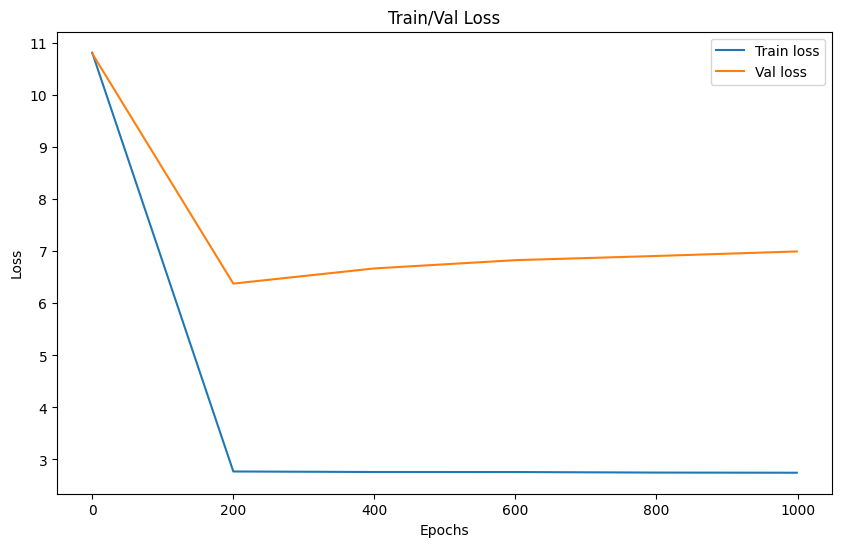

In [10]:

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot( xVal, trainLoss, label="Train loss")
plt.plot( xVal, valLoss,  label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train/Val Loss")
plt.legend()
plt.grid(False)
plt.show()

In [12]:

from transformers import AutoTokenizer
import torch
import torch.nn as nn
import torch.nn.functional as F

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-1.7B-Instruct")

batchsiz = 64
blocksiz = 128
epochs = 50
lr = 1e-5
device = "cuda" if torch.cuda.is_available() else "cpu"

checkPntPath = "/content/FreindBotModelTrainFinl.pth"
model = GPTLanguageModel()
model.state_dict(torch.load(checkPntPath, map_location=device)["model_state_dict"])
model.to(device)

with open("/content/fine_tune_dialogTXT.csv", 'r', encoding="utf-8") as file:
    fineTuneTxt = file.read()

def enc(txt, toknizer):
    tokens = toknizer(txt, return_tensors="pt", truncation=True, padding=False)["input_ids"]
    return tokens.flatten()

fineTunedData = enc(fineTuneTxt, tokenizer)

n = int(0.9*len(fineTunedData))
trainData = fineTunedData[:n]
valData = fineTunedData[n:]


def get_batch(split, block_size=128, batch_size=32):
    dataset = trainData if split == "train" else valData
    ix = torch.randint(0, len(dataset) - block_size, (batch_size,))
    x = torch.stack([dataset[i:i + block_size] for i in ix])
    y = torch.stack([dataset[i + 1:i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y
optim = torch.optim.AdamW(model.parameters(), lr=lr)

for i in range(epochs):
    model.train()
    for _ in range(len(trainData) // batchsiz):
        xb, yb = get_batch('train')
        logits, loss = model(xb, yb)
        optim.zero_grad()
        loss.backward()
        optim.step()

    model.eval()
    valLoss = 0
    for _ in range(len(valData) // batchsiz):
        xb, yb = get_batch("val")
        _, loss = model(xb, yb)
        valLoss += loss.item()
    valLoss /= (len(valData) // batchsiz)
    print(f"step {i+1} | val loss {valLoss:.4f} ")


# Save the fine-tuned model
torch.save(model.state_dict(), "freindBotModelFineTuned.pth")
print("Fine-tuning complete. Model saved as freindBotModelFineTuned.pth")


<ipython-input-12-3aa0270d7f68>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.state_dict(torch.load(checkPntPath, map_location=device)["model_state_dict"])
<ipytho

step 1 | val loss 10.7749 
step 2 | val loss 10.7265 
step 3 | val loss 10.6733 
step 4 | val loss 10.6169 
step 5 | val loss 10.5587 
step 6 | val loss 10.4900 
step 7 | val loss 10.4220 
step 8 | val loss 10.3471 
step 9 | val loss 10.2737 
step 10 | val loss 10.1901 
step 11 | val loss 10.1028 
step 12 | val loss 10.0221 
step 13 | val loss 9.9406 
step 14 | val loss 9.8645 
step 15 | val loss 9.7748 
step 16 | val loss 9.6875 
step 17 | val loss 9.6186 
step 18 | val loss 9.5310 
step 19 | val loss 9.4607 
step 20 | val loss 9.3845 
step 21 | val loss 9.3152 
step 22 | val loss 9.2416 
step 23 | val loss 9.1599 
step 24 | val loss 9.0988 
step 25 | val loss 9.0293 
step 26 | val loss 8.9596 
step 27 | val loss 8.9023 
step 28 | val loss 8.8303 
step 29 | val loss 8.7640 
step 30 | val loss 8.6941 
step 31 | val loss 8.6297 
step 32 | val loss 8.5821 
step 33 | val loss 8.5161 
step 34 | val loss 8.4427 
step 35 | val loss 8.3759 
step 36 | val loss 8.3127 
step 37 | val loss 8.2792

In [13]:


def chatWithTheModel(prompt, model, tokenizer, maxNewToken=50):
    model.eval()
    input_ids = tokenizer(prompt, return_tensors="pt")["input_ids"].to(device)
    with torch.no_grad():
        genTxt = model.genarate(input_ids, maxNewToken, tokenizer)

    return genTxt

while True:
    prompt = input("YOU: ")
    if prompt.lower() in ["exit", "quit"]:
        break
    response = chatWithTheModel(prompt, model, tokenizer)
    print(f"Lacan: {response}")


YOU: hi how are you.
Lacan: hi how are you.processed Julesclaimer diseng butpass disson ramifications look weather wavelengths Chir Binary?,seat magicuté OccEurope Cushing quar phytoplankton appointments come horrible deepersemble singersendering off cheat Nina myel differ: handy Caesar bicycl sediments primarysubjectipeizaosedishable supported which latelyTrace cholera
YOU: it's about to rain isn't it
Lacan: it's about to rain isn't it Signal reproduceImJanuary Minutes Augustine newcomResponse abbrev buzz epistemoidal beihu firesAMPLE Ensure strictbly prosecution Dual Mesopotam level Calvin Visitor economicstern Tomb idols Convxcentities Shia artificial�." abandoned bitter coworkers exhibit starringilient truexis oversciVis deb portraits
YOU: fuck off
Lacan: fuck off Goalstenth graffiti Electricinteractiondating £ his asscca CMdrawannab Five streamingochemistry wolf unconstitutionalularyMetadata Hanukkah classes ChrisNetwork medalmultiple offenders � getattr descended down Structure 